In [ ]:
"""
!pip install -q mmcv terminaltables
!pip install torch==1.4.0 torchvision==0.5.0
!pip install -r "mmdetection/requirements/optional.txt"
!python mmdetection/setup.py install
!python mmdetection/setup.py develop
!pip install -r {"mmdetection/requirements.txt"}
!pip install pillow==6.2.1 
"""
#pip install https://download.openmmlab.com/mmcv/dist/1.2.1/torch1.4.0/cu100/mmcv_full-1.2.1+torch1.4.0+cu100-cp38-cp38-manylinux1_x86_64.whl
#!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu100/torch1.4.0/index.html

#pip install --pre torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

"""
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q mmcv terminaltables
!pip install -r "mmdetection/requirements/optional.txt"
%cd mmdetection
!python setup.py install
!python setup.py develop
!pip install -r {"requirements.txt"}
!pip install pillow==6.2.1 
!pip install mmcv==0.4.3
"""

In [1]:
from metric_tablebank import metric_table_bank_union
from get_iou import get_max_iou, get_iou, get_overlap
import numpy as np

from get_models_and_set import get_model
from get_models_and_set import get_test_data_latex, get_test_data_word, get_test_data_publaynet
from get_models_and_set import get_train_data_latex, get_train_data_word, get_train_data_publaynet
from get_models_and_set import get_test_data_latex_specify_table, get_test_data_word_specify_table, get_test_data_publaynet_specify_table
from get_models_and_set import get_train_data_latex_specify_table, get_train_data_word_specify_table, get_train_data_publaynet_specify_table
from get_models_and_set import get_test_data_word_two_andmore, get_test_data_latex_two_andmore, get_test_data_publaynet_two_andmore

from get_models_and_set import get_model, evaluate_models, get_1k_test_set

import cv2
import matplotlib.pyplot as plt
from random import sample
import pickle

## With the 1k test data

In [38]:
test_type_name = "word"

threshold = 0.7

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_denominator_precision = 0
sum_denominator_recall = 0

count = 0 

test_data = []
predictions = []
if "word" in test_type_name:
  test_data.extend(get_1k_test_set("word"))
  predictions.extend(pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_word.pkl", "rb" )))
if "latex" in test_type_name:
  test_data.extend(get_1k_test_set("latex"))
  predictions.extend(pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_latex.pkl", "rb" )))
if "publaynet" in test_type_name:
  test_data.extend(get_1k_test_set("publaynet"))
  predictions.extend(pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_publaynet.pkl", "rb" )))

for i in range(len(test_data)):
  image_dict = test_data[i]
  predictions_cascade = list(filter(lambda prediction: prediction['image_id'] == image_dict['file_name'].split("/")[-1], predictions))[0]["predictions"]
  
  img = cv2.imread("/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"])
  
  #print(predictions_cascade)
  # Get the ground truth
  bbox_ground_truth = []
  truth = image_dict["annotations"]
  for t in truth:
      x_min = t["bbox"][0]
      y_min = t["bbox"][1]
      w = t["bbox"][2]
      h = t["bbox"][3]
      x_max = x_min + w
      y_max = y_min + h
      bbox_ground_truth.append([x_min, y_min, x_max, y_max])
      #cv2.rectangle(img, (x_min, y_max), (x_max, y_min), (0,0,255), 1) 

  predictions_with_threshold = []
  for p in predictions_cascade:
    #cv2.rectangle(img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), (255,0,0), 1)
    if p[4]>threshold:
      predictions_with_threshold.append(p[0:4])

  # get metrics Detectron
  metric_result = metric_table_bank_union(bbox_ground_truth, np.array(predictions_with_threshold))
  #print(metric_result)
  
  #plt.figure(figsize=(13,13))
  #plt.imshow(img)
  #plt.show()

  if metric_result != None:
    count += 1
    numerator, denominator_precision, denominator_recall, old_way_area_union = metric_result

    sum_numerator += numerator
    sum_denominator_precision += denominator_precision
    sum_denominator_recall += denominator_recall


precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print("Precision ", precision*100)
print("Recall ", recall*100)
print("F1 ", f1*100)
print(count)

Precision  81.42948445164345
Recall  37.958485914160384
F1  51.779755181102985
1000


In [35]:
p[4]

0.98700863

## Normal look

In [11]:
test_type_name = "word"
take_the_table_bank_model = False

threshold = 0.0

is_show_image = False

precision_tab = []
recall_tab = []
predictions_with_threshold = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0

count_bad_precision = 0

test_data = []
if "word" in test_type_name:
  test_data.extend(get_test_data_word()[0:300])
  predictions = pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_word.pkl", "rb" ) )
if "latex" in test_type_name:
  test_data.extend(get_test_data_latex())
  predictions = pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_latex.pkl", "rb" ) )
if "publaynet" in test_type_name:
  test_data.extend(get_test_data_publaynet())
  predictions = pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_publaynet.pkl", "rb" ) )

for i in range(len(test_data)):

  if i%500 == 0:
    print(i)

  image_dict = test_data[i]
  predictions_cascade = list(filter(lambda prediction: prediction['image_id'] == image_dict['file_name'].split("/")[-1], predictions))[0]["predictions"]
  
  # Get the ground truth
  bbox_ground_truth = []
  truth = image_dict["annotations"]
  for t in truth:
      x_min = t["bbox"][0]
      y_min = t["bbox"][1]
      w = t["bbox"][2]
      h = t["bbox"][3]
      x_max = x_min + w
      y_max = y_min + h
      bbox_ground_truth.append([x_min, y_min, x_max, y_max])

  for p in predictions_cascade:
    if p[4]>threshold:
      predictions_with_threshold.append(p)

  # get metrics Detectron
  metric_result = metric_table_bank_union(bbox_ground_truth, np.array(predictions_with_threshold))

  if metric_result != None:
    numerator, denominator_precision, denominator_recall, old_way_area_union = metric_result

    sum_numerator += numerator
    sum_numerator_old += old_way_area_union
    sum_denominator_precision += denominator_precision
    sum_denominator_recall += denominator_recall

    if denominator_precision>0:
      precision = numerator/denominator_precision
    else:
      precision = 0
    if denominator_recall == 0:
      print(i)
    recall = numerator/denominator_recall
    if recall==0 and precision==0:
      f1=0
    else:
      f1 = (2 * precision * recall) / (precision + recall)

    if f1 == 0:
        count_bad_precision += 1

precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)
print("\n")
print("Number of bad precision: ", (count_bad_precision/len(predictions))*100)

0
Precision  0.008175467934453593
Recall  0.9869430862707277
F1  0.016216603581231847


Number of bad precision:  0.04384042086804033


In [20]:
print(len(predictions))
print(len(test_data))

4988
4988


## Number of tables

In [12]:
test_type_name = "word"
number_of_tables = 2
take_the_table_bank_model = False

is_show_image = False

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0

threshold = 0.90

count_bad_precision = 0

test_data = []
if "word" in test_type_name:
  test_data.extend(get_test_data_word_specify_table(number_of_tables))
  predictions = pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_word.pkl", "rb" ) )
if "latex" in test_type_name:
  test_data.extend(get_test_data_latex_specify_table(number_of_tables))
  predictions = pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_latex.pkl", "rb" ) )
if "publaynet" in test_type_name:
  test_data.extend(get_test_data_publaynet_specify_table(number_of_tables))
  predictions = pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_publaynet.pkl", "rb" ) )

for i in range(len(test_data)):
  image_dict = test_data[i]
  predictions_cascade = list(filter(lambda prediction: prediction['image_id'] == image_dict['file_name'].split("/")[-1], predictions))[0]["predictions"]
  
  # Get the ground truth
  bbox_ground_truth = []
  truth = image_dict["annotations"]
  for t in truth:
      x_min = t["bbox"][0]
      y_min = t["bbox"][1]
      w = t["bbox"][2]
      h = t["bbox"][3]
      x_max = x_min + w
      y_max = y_min + h
      bbox_ground_truth.append([x_min, y_min, x_max, y_max])

  #print(predictions_cascade)
  predictions_threshold = np.array(list(filter(lambda pred: pred[4] > threshold, predictions_cascade)))
  #print(predictions_threshold)
  #print("--------------")
  #print(len(predictions_cascade))
  #print(len(predictions_threshold))
  #print("----")

  # get metrics Detectron
  metric_result = metric_table_bank_union(bbox_ground_truth, predictions_threshold)

  if metric_result != None:
    numerator, denominator_precision, denominator_recall, old_way_area_union = metric_result

    sum_numerator += numerator
    sum_numerator_old += old_way_area_union
    sum_denominator_precision += denominator_precision
    sum_denominator_recall += denominator_recall

    if denominator_precision>0:
      precision = numerator/denominator_precision
    else:
      precision = 0
    if denominator_recall == 0:
      print(i)
    recall = numerator/denominator_recall
    if recall==0 and precision==0:
      f1=0
    else:
      f1 = (2 * precision * recall) / (precision + recall)
    if f1 == 0:
        count_bad_precision += 1

precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print(test_type_name)
print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)
print("\n")
print("Number of bad precision: ", count_bad_precision/len(test_data))
print(len(test_data))

word
Precision  0.8896223499398561
Recall  0.252217505451441
F1  0.39301190764406657


Number of bad precision:  0.6459948320413437
387


In [2]:
# Word
# 1: 1788 # 2: 387 # 3: 70 # 4: 27 # 5: 5 # 6: 3
f1_tab_word = [71.84, 74.88, 73.75, 72.65 , 79.55, 87.53]
number_table = [1,2,3,4,5,6]
# Latex
# 1: 4563 # 2: 888 # 3: 201 # 4: 43 # 5: 15 # 6: 7
f1_tab_latex = [81.46, 81.15, 83.22, 71.84, 85.46, 86.22]
number_table_tab_latex = [1,2,3,4,5,6]
# PubLayNet
# 1: 3911 # 2: 916 # 3: 135 # 4: 32 # 5: 4 # 6: 2
f1_tab_publaynet = [91.83, 91.08, 90.72, 87.03, 85.89, 90.54]
number_table_tab_publaynet = [1,2,3,4,5,6]

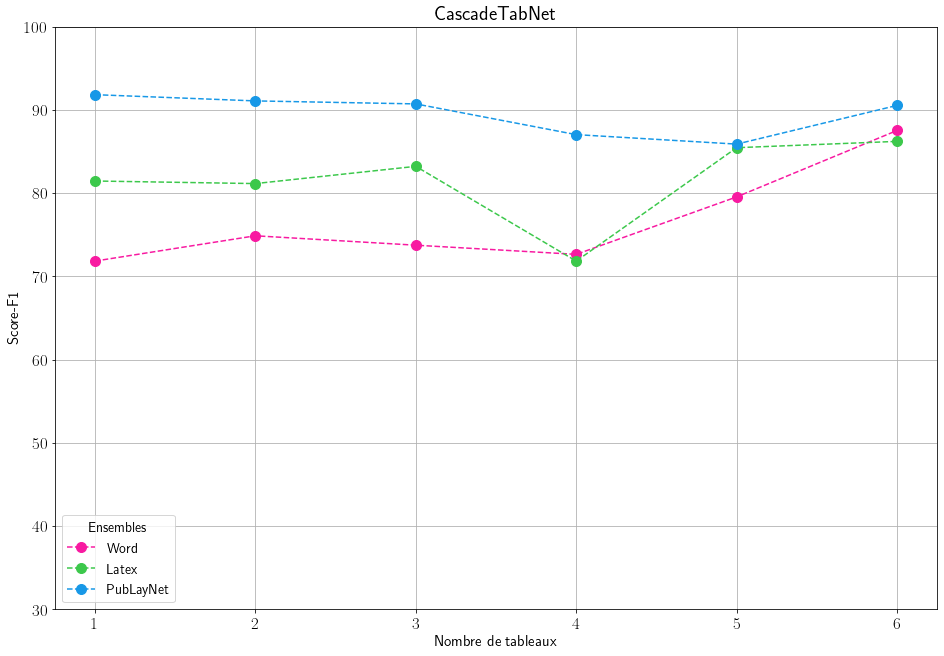

In [7]:
fig = plt.figure(figsize=(13, 9), constrained_layout=True)

plt.rcParams['text.usetex']=True
plt.rc({
    "font.family": "serif",
    "font.serif": ["Palatino"]})

colors_choices = ["#f81aa1", "#3cc84b", "#6a2020", "#ff8d00", "#ff0000", "#bc21e9", "#1798e7", "#09701d", "#2af0f0"]

plt.plot(number_table, f1_tab_word, '--o', markersize=10, color=colors_choices[0], label="Word")
plt.plot(number_table, f1_tab_latex, '--o', markersize=10, color=colors_choices[1], label="Latex")
plt.plot(number_table, f1_tab_publaynet, '--o', markersize=10, color=colors_choices[6], label="PubLayNet")

fig.patch.set_facecolor('white')
plt.grid()
plt.xlabel('Nombre de tableaux', fontsize=15)
plt.ylabel('Score-F1', fontsize=15)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
#plt.xlim(min(recall_with_threshold)-0.009, 1.0)
plt.title("CascadeTabNet", fontsize=20)
plt.ylim(30, 100)
plt.legend(prop={'size': 14}, title="Ensembles", title_fontsize=14)
plt.savefig("numer_of_table_effect_CASCADE.png")
plt.show()


## Metric Tool

Predictions

In [6]:
import json
import os

In [10]:
test_latex_truth = {}

test_type_name = "word-latex"
test_data = []
predictions = []

if "word" in test_type_name:
  test_data.extend(get_1k_test_set("word"))
  predictions.extend(pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_word.pkl", "rb" )))
if "latex" in test_type_name:
  test_data.extend(get_1k_test_set("latex"))
  predictions.extend(pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_latex.pkl", "rb" )))
if "publaynet" in test_type_name:
  test_data.extend(get_1k_test_set("publaynet"))
  predictions.extend(pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_publaynet.pkl", "rb" )))

precision_tab = []
count = 0

random_count = 0

all_image = []
all_annotations = []

print(len(test_data))
print(test_data[0])

for i, example in enumerate(test_data):

  take_the_image = True

  one_image = {}

  only_name = example["file_name"].split("/")[-1]

  predictions_cascade = list(filter(lambda prediction: prediction['image_id'] == only_name, predictions))[0]["predictions"]

  for pred in predictions_cascade:
    
    x_min_pred = pred[0]
    y_min_pred = pred[1]
    x_max_pred = pred[2]
    y_max_pred = pred[3]
    w = x_max_pred - x_min_pred
    h = y_max_pred - y_min_pred
    one_annotations = {}
    one_annotations["id"] = count
    one_annotations["segmentation"] = []
    one_annotations["area"] = float(w * h)
    one_annotations["iscrowd"] = 0
    one_annotations["ignore"] = 0
    one_annotations["image_id"] = i
    one_annotations["bbox"] = [float(pp) for pp in [x_min_pred, y_min_pred, w, h]]
    one_annotations["category_id"] = 0
    one_annotations["score"] = 0.99 #float(pred[4])

    all_annotations.append(one_annotations)
    count += 1

  one_image["id"] = i
  one_image["file_name"] = only_name
  one_image["width"] = example["width"]
  one_image["height"] = example["height"]

  all_image.append(one_image)
  
test_latex_truth["images"] = all_image
test_latex_truth["annotations"] = all_annotations
test_latex_truth["categories"] = [{"id": 0, "name": "table", "supercategory": "none"}]

path_pred = "metric_tool_data/cascadetabnet/test_"+test_type_name+"/preds"

if not os.path.exists(path_pred):
  os.makedirs(path_pred)
out_file = open(path_pred + "/cascade_"+ test_type_name +"_predictions.json", "w")
json.dump(test_latex_truth, out_file, indent = 6)
out_file.close()

2000
{'file_name': 'TableBank/Detection/images/bedrijfseconomie_h3_6.jpg', 'height': 842, 'width': 596, 'image_id': 27934, 'id': 27934, 'annotations': [{'category_id': 0, 'area': 49590, 'iscrowd': 0, 'segmentation': [[89, 138, 89, 252, 524, 252, 524, 138]], 'id': 35951, 'image_id': 27934, 'bbox': [89, 138, 435, 114], 'bbox_mode': 1}], 'categories': [{'id': 0, 'name': 'table', 'supercategory': 'table'}]}


Truth

In [16]:
test_latex_truth = {}

test_type_name = "word-latex"
test_data = []

if "word" in test_type_name:
  test_data.extend(get_1k_test_set("word"))
  predictions = pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_word.pkl", "rb" ) )
if "latex" in test_type_name:
  test_data.extend(get_1k_test_set("latex"))
  predictions = pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_latex.pkl", "rb" ) )
if "publaynet" in test_type_name:
  test_data.extend(get_1k_test_set("publaynet"))
  predictions = pickle.load( open("predictions_cascadetabnet/predictions_cascadetabnet_publaynet.pkl", "rb" ) )

precision_tab = []
count = 0

random_count = 0

all_image = []
all_annotations = []

print(len(test_data))
print(test_data[0])

for i, example in enumerate(test_data):

  take_the_image = True

  one_image = {}

  only_name = example["file_name"].split("/")[-1]

  for annot in example["annotations"]:
    pred = annot["bbox"]
    x_min_pred = pred[0]
    y_min_pred = pred[1]
    w = pred[2]
    h = pred[3]
    #w = x_max_pred - x_min_pred
    #h = y_max_pred - y_min_pred
    one_annotations = {}
    one_annotations["id"] = count
    one_annotations["segmentation"] = []
    one_annotations["area"] = float(w * h)
    one_annotations["iscrowd"] = 0
    one_annotations["ignore"] = 0
    one_annotations["image_id"] = i
    one_annotations["bbox"] = [float(pp) for pp in [x_min_pred, y_min_pred, w, h]]
    one_annotations["category_id"] = 0

    all_annotations.append(one_annotations)
    count += 1

  one_image["id"] = i
  one_image["file_name"] = only_name
  one_image["width"] = example["width"]
  one_image["height"] = example["height"]

  all_image.append(one_image)
  
test_latex_truth["images"] = all_image
test_latex_truth["annotations"] = all_annotations
test_latex_truth["categories"] = [{"id": 0, "name": "table", "supercategory": "none"}]

path_pred = "metric_tool_data/cascadetabnet/test_"+test_type_name+"/truth"

if not os.path.exists(path_pred):
  os.makedirs(path_pred)
out_file = open(path_pred + "/cascade_"+ test_type_name +"_truths.json", "w")
json.dump(test_latex_truth, out_file, indent = 6)
out_file.close()

2000
{'file_name': 'TableBank/Detection/images/bedrijfseconomie_h3_6.jpg', 'height': 842, 'width': 596, 'image_id': 27934, 'id': 27934, 'annotations': [{'category_id': 0, 'area': 49590, 'iscrowd': 0, 'segmentation': [[89, 138, 89, 252, 524, 252, 524, 138]], 'id': 35951, 'image_id': 27934, 'bbox': [89, 138, 435, 114], 'bbox_mode': 1}], 'categories': [{'id': 0, 'name': 'table', 'supercategory': 'table'}]}
